# INFO 2950 - Phase II

## Research Question
Is there a relationship between food availability, both grocery stores and restaurants, and county demographics across the United States? Are there specific kinds of grocery stores and restaurants depending on the demographics in the county? Is there a relationship between grocery stores and fast food restaurants within each county? 

## Data Descriptions

For this project we are primarily examining the Food Enviroment Atlas Data from the USDA. This data set, organized into multiple tabs of an Excel file, splits data into counties of the United States. It has a tab for data on each county's population, income and access to stores, grocery stores, restaurants, assisstance (such as SNAP and WIC), food insecurity, taxes, local food outlets, health, and socioeconomic demographics. We are choosing to look at the data sets about grocery stores, restaurants, and socioeconomic demographics.

- What are the observations (rows) and the attributes (columns)?

    - In all three of our datasets, the rows represent counties in the United States. Each row corresponds to one county. The columns have county-level data for each county.
    - In the stores dataset, the columns correspond to figures about access to grocery stores, including:
        - Number of grocery stores, 2011
        - Number of grocery stores, 2016
        - Number of grocery stores per 1000 people, 2011
        - Number of grocery stores per 1000 people, 2016
        - Subsequent columns with the same information for convenience stores, specialty food stores, and supercenters (like Costco)
    - In the Restaurants dataset, the columns correspond to figures about access to restaurants, including:
        - Number of fast food restaurants, 2011
        - Number of fast food restaurants, 2016
        - Number of fast food restaurants per 1000 people, 2011
        - Number of fast food restaurants per 1000 people, 2016
        - Subsequent columns with the same information for full service restaurants
        - Fast food expenditures per capita, 2012
        - Full-service restaurant expenditures per capita, 2012
    - In the demographics dataset, the columns correspond to figures about the demographic breakdowns of the counties, including:
        - % of population that’s White
        - % of population that’s Black
        - % of population that’s Asian
        - % of population that’s Native American
        - % of population that’s Hawaiian or Pacific Islander
        - % of population that’s Hispanic
        - Median Household Income, 2015
        - Poverty Rate, 2015
        - Child Poverty Rate, 2015
        - Contains a metropolitan area (binary variable)

- Why was this dataset created?

The stated objective of the Food Environmental Atlas:

“The objectives of the Atlas are:to assemble statistics on food environment indicators to stimulate research on the determinants of food choices and diet quality, and to provide a spatial overview of a community's ability to access healthy food and its success in doing so.”

- Who funded the creation of the dataset?

The Food Envitonmental Atlas was created by the USDA (U.S. Department of Agriculture)

- What processes might have influenced what data was observed and recorded and what was not?

The data in the Atlas comes from a wide variety of sources, so it is difficult to ascertain processes for every form of data collection The different data used to generate the indicators in the Atlas is documented here: https://www.ers.usda.gov/data-products/food-environment-atlas/documentation/ One limitation of the data is that all of these indicators are subject to rapid change. The dataset attempts to deal with this by providing data from multiple years for each indicator wherever possible, but it is likely that data on number of grocery stores or restaurants in a county, for example, will fluctuate over time.

- What preprocessing was done, and how did the data come to be in the form that you are using?

We downloaded three separate excel sheets from the Atlas, and converted them into csv files. We dropped several columns from each dataset that were irrelevant to our research questions, and then re-named the columns to be more understandable. We checks for gaps in the data and found a few missing data points in the Poverty Rate, Child Poverty rate, and Median Household Income columns, so we imputed NaN into those spots.

- If people are involved, were they aware of the data collection and if so, what purpose did they expect the data to be used for?

Data in the Atlas was aggregated from a variety of sources, none of which seem to have included direct contact with individuals. The closest thing would be demographic data derived from census data, and generally speaking people who fill out the census are aware that information is used for data collection. They may not have know it would be used specifically for this purpose.

- Where can your raw source data be found, if applicable?

https://www.ers.usda.gov/data-products/food-environment-atlas/data-access-and-documentation-downloads/



In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import duckdb
from sklearn.linear_model import LinearRegression, LogisticRegression

## Data Cleaning

The original data was contained in an excel file, with each subjet on a different tab. The first step was to download each tab we were working with as a csv. We started with the grocery stores data.

In [25]:
stores = pd.read_csv('data/Store_Access.csv')
stores.head()

,FIPS,State,County,GROC11,GROC16,PCH_GROC_11_16,GROCPTH11,GROCPTH16,PCH_GROCPTH_11_16,SUPERC11,...,PCH_SNAPS_12_17,SNAPSPTH12,SNAPSPTH17,PCH_SNAPSPTH_12_17,WICS11,WICS16,PCH_WICS_11_16,WICSPTH11,WICSPTH16,PCH_WICSPTH_11_16
0,1001,AL,Autauga,5,3,-40.000000,0.090581,0.054271,-40.085748,1,...,19.376392,0.674004,0.804747,19.397900,5.0,5.0,0.000000,0.090567,0.090511,-0.061543
1,1003,AL,Baldwin,27,29,7.407407,0.144746,0.139753,-3.449328,6,...,36.927711,0.725055,0.890836,22.864524,26.0,28.0,7.692307,0.139380,0.134802,-3.284727
2,1005,AL,Barbour,6,4,-33.333333,0.219370,0.155195,-29.254287,0,...,3.349282,1.280590,1.424614,11.246689,7.0,6.0,-14.285714,0.255942,0.232387,-9.203081
3,1007,AL,Bibb,6,5,-16.666667,0.263794,0.220916,-16.254289,1,...,11.794872,0.719122,0.801423,11.444711,6.0,5.0,-16.666666,0.263771,0.221474,-16.035471
4,1009,AL,Blount,7,5,-28.571429,0.121608,0.086863,-28.571429,1,...,5.701754,0.657144,0.692374,5.361034,8.0,8.0,0.000000,0.139000,0.139089,0.064332


Next, we determined which columns we would potentially want to use based on our reseach questions, and dropped the rest from our data frame.

In [26]:
stores = stores.drop(['PCH_GROCPTH_11_16',\
                      'PCH_SUPERCPTH_11_16',\
                      'PCH_CONVSPTH_11_16',\
                      'PCH_SPECSPTH_11_16',\
                      'SNAPS12','SNAPS17',\
                      'PCH_SNAPS_12_17',\
                      'SNAPSPTH12',\
                      'SNAPSPTH17',\
                      'PCH_SNAPSPTH_12_17',\
                      'WICS11','WICS16',\
                      'PCH_WICS_11_16',\
                      'WICSPTH11',\
                      'WICSPTH16',\
                      'PCH_WICSPTH_11_16',\
                      'FIPS',\
                      'PCH_SUPERC_11_16',\
                      'PCH_GROC_11_16',\
                      'PCH_CONVS_11_16',\
                      'PCH_SPECS_11_16'], axis=1)
stores.head()

,State,County,GROC11,GROC16,GROCPTH11,GROCPTH16,SUPERC11,SUPERC16,SUPERCPTH11,SUPERCPTH16,CONVS11,CONVS16,CONVSPTH11,CONVSPTH16,SPECS11,SPECS16,SPECSPTH11,SPECSPTH16
0,AL,Autauga,5,3,0.090581,0.054271,1,1,0.018116,0.018090,31,31,0.561604,0.560802,1,1,0.018116,0.018090
1,AL,Baldwin,27,29,0.144746,0.139753,6,7,0.032166,0.033733,107,118,0.573622,0.568650,20,27,0.107219,0.130115
2,AL,Barbour,6,4,0.219370,0.155195,0,1,0.000000,0.038799,22,19,0.804358,0.737177,3,2,0.109685,0.077598
3,AL,Bibb,6,5,0.263794,0.220916,1,1,0.043966,0.044183,19,15,0.835348,0.662749,0,0,0.000000,0.000000
4,AL,Blount,7,5,0.121608,0.086863,1,1,0.017373,0.017373,30,27,0.521177,0.469059,1,0,0.017373,0.000000


The data from the USDA had a tab in the Excel file that explained what each variable meant, and then used the variable names as the titles for the columns in the rest of the tabs. For our purposes, we wanted to convert the variable names back to their real names so we could see their meaning easily by looking at our data frame. To do so, we referred to the variable tab and manually renamed each column to easily understand its meaning.

In [27]:
stores = stores.rename(columns={'GROC11':'Grocery_2011',
                                'GROC16': 'Grocery_2016', 
                                'GROCPTH11':'Grocery_per_1000_2011', 
                                'GROCPTH16':'Grocery_per_1000_2016', 'SUPERC11': 'Supercenter_2011', 
                                'SUPERC16': 'Supercenter_2016', 
                                'SUPERCPTH11':'Supercenter_per_1000_2011',
                                'SUPERCPTH16':'Supercenter_per_1000_2016', 
                                'CONVS11':'Convenience_2011', 'CONVS16':'Convenience_2016', 
                                'CONVSPTH11':'Convenience_per_1000_2011',
                                'CONVSPTH16':'Convenience_per_1000_2016', 
                                'SPECS11':'Specialized_2011', 
                                'SPECS16':'Specialized_2016', 
                                'SPECSPTH11':'Specialized_per_1000_2011', 
                                'SPECSPTH16':'Specialized_per_1000_2016'})
stores.head()                                
                                

,State,County,Grocery_2011,Grocery_2016,Grocery_per_1000_2011,Grocery_per_1000_2016,Supercenter_2011,Supercenter_2016,Supercenter_per_1000_2011,Supercenter_per_1000_2016,Convenience_2011,Convenience_2016,Convenience_per_1000_2011,Convenience_per_1000_2016,Specialized_2011,Specialized_2016,Specialized_per_1000_2011,Specialized_per_1000_2016
0,AL,Autauga,5,3,0.090581,0.054271,1,1,0.018116,0.018090,31,31,0.561604,0.560802,1,1,0.018116,0.018090
1,AL,Baldwin,27,29,0.144746,0.139753,6,7,0.032166,0.033733,107,118,0.573622,0.568650,20,27,0.107219,0.130115
2,AL,Barbour,6,4,0.219370,0.155195,0,1,0.000000,0.038799,22,19,0.804358,0.737177,3,2,0.109685,0.077598
3,AL,Bibb,6,5,0.263794,0.220916,1,1,0.043966,0.044183,19,15,0.835348,0.662749,0,0,0.000000,0.000000
4,AL,Blount,7,5,0.121608,0.086863,1,1,0.017373,0.017373,30,27,0.521177,0.469059,1,0,0.017373,0.000000


Next, we converted the demographics tab of the Excel sheet into a csv and performed the same procedure on the demographics data frame, first dropping the columns that were unnecessary in relation to our research questions, and the convert the column names back to their titles based on the variable codes.

In [28]:
demographics = pd.read_csv('data/county_demographics.csv')
demographics.head()

,FIPS,State,County,PCT_NHWHITE10,PCT_NHBLACK10,PCT_HISP10,PCT_NHASIAN10,PCT_NHNA10,PCT_NHPI10,PCT_65OLDER10,PCT_18YOUNGER10,MEDHHINC15,POVRATE15,PERPOV10,CHILDPOVRATE15,PERCHLDPOV10,METRO13,POPLOSS10
0,1001,AL,Autauga,77.246156,17.582599,2.400542,0.855766,0.397647,0.040314,11.995382,26.777959,56580.0,12.7,0,18.8,0,1,0.0
1,1003,AL,Baldwin,83.504787,9.308425,4.384824,0.735193,0.628755,0.043343,16.771185,22.987408,52387.0,12.9,0,19.6,0,1,0.0
2,1005,AL,Barbour,46.753105,46.691190,5.051535,0.389700,0.218524,0.087409,14.236807,21.906982,31433.0,32.0,1,45.2,1,0,0.0
3,1007,AL,Bibb,75.020729,21.924504,1.771765,0.096007,0.279293,0.030548,12.681650,22.696923,40767.0,22.2,0,29.3,1,1,0.0
4,1009,AL,Blount,88.887338,1.263040,8.070200,0.200621,0.497191,0.031402,14.722096,24.608353,50487.0,14.7,0,22.2,0,1,0.0


In [29]:
demographics = demographics.drop(['PCT_65OLDER10', 'PCT_18YOUNGER10', 'PERPOV10', 'PERCHLDPOV10', \
                                 'POPLOSS10', 'FIPS'], axis=1)
demographics.head()

,State,County,PCT_NHWHITE10,PCT_NHBLACK10,PCT_HISP10,PCT_NHASIAN10,PCT_NHNA10,PCT_NHPI10,MEDHHINC15,POVRATE15,CHILDPOVRATE15,METRO13
0,AL,Autauga,77.246156,17.582599,2.400542,0.855766,0.397647,0.040314,56580.0,12.7,18.8,1
1,AL,Baldwin,83.504787,9.308425,4.384824,0.735193,0.628755,0.043343,52387.0,12.9,19.6,1
2,AL,Barbour,46.753105,46.691190,5.051535,0.389700,0.218524,0.087409,31433.0,32.0,45.2,0
3,AL,Bibb,75.020729,21.924504,1.771765,0.096007,0.279293,0.030548,40767.0,22.2,29.3,1
4,AL,Blount,88.887338,1.263040,8.070200,0.200621,0.497191,0.031402,50487.0,14.7,22.2,1


In [30]:
demographics = demographics.rename(columns={
    'PCT_NHWHITE10': 'Percent_White_2010',
    'PCT_NHBLACK10': 'Percent_Black_2010',
    'PCT_HISP10': 'Percent_Hispanic_2010',
    'PCT_NHASIAN10': 'Percent_Asian_2010',
    'PCT_NHNA10': 'Percent_Native_American_2010',
    'PCT_NHPI10': 'Percent_Hawaiian_2010',
    'MEDHHINC15': 'Median_household_income_2015',
    'POVRATE15': 'Poverty_Rate_2015',
    'CHILDPOVRATE15': 'Child_poverty_rate_2015',
    'METRO13': 'Metro'
})
demographics.head()

,State,County,Percent_White_2010,Percent_Black_2010,Percent_Hispanic_2010,Percent_Asian_2010,Percent_Native_American_2010,Percent_Hawaiian_2010,Median_household_income_2015,Poverty_Rate_2015,Child_poverty_rate_2015,Metro
0,AL,Autauga,77.246156,17.582599,2.400542,0.855766,0.397647,0.040314,56580.0,12.7,18.8,1
1,AL,Baldwin,83.504787,9.308425,4.384824,0.735193,0.628755,0.043343,52387.0,12.9,19.6,1
2,AL,Barbour,46.753105,46.691190,5.051535,0.389700,0.218524,0.087409,31433.0,32.0,45.2,0
3,AL,Bibb,75.020729,21.924504,1.771765,0.096007,0.279293,0.030548,40767.0,22.2,29.3,1
4,AL,Blount,88.887338,1.263040,8.070200,0.200621,0.497191,0.031402,50487.0,14.7,22.2,1


Then, we converted the restaurants tab of the Excel sheet into a csv file, created another data frame, dropped the columns we were not interested in, and changed the column names from the variable codes. 

In [31]:
restaurants = pd.read_csv('data/Restaurants.csv')
restaurants.head()

,FIPS,State,County,FFR11,FFR16,PCH_FFR_11_16,FFRPTH11,FFRPTH16,PCH_FFRPTH_11_16,FSR11,FSR16,PCH_FSR_11_16,FSRPTH11,FSRPTH16,PCH_FSRPTH_11_16,PC_FFRSALES07,PC_FFRSALES12,PC_FSRSALES07,PC_FSRSALES12
0,1001,AL,Autauga,34,44,29.411765,0.615953,0.795977,29.226817,32,31,-3.125000,0.579721,0.560802,-3.263448,649.511367,674.80272,484.381507,512.280987
1,1003,AL,Baldwin,121,156,28.925620,0.648675,0.751775,15.893824,216,236,9.259259,1.157966,1.137300,-1.784662,649.511367,674.80272,484.381507,512.280987
2,1005,AL,Barbour,19,23,21.052632,0.694673,0.892372,28.459320,17,14,-17.647059,0.621549,0.543183,-12.608237,649.511367,674.80272,484.381507,512.280987
3,1007,AL,Bibb,6,7,16.666667,0.263794,0.309283,17.243995,5,7,40.000000,0.219829,0.309283,40.692794,649.511367,674.80272,484.381507,512.280987
4,1009,AL,Blount,20,23,15.000000,0.347451,0.399569,15.000000,15,12,-20.000000,0.260589,0.208471,-20.000000,649.511367,674.80272,484.381507,512.280987


In [32]:
restaurants = restaurants.drop(['PCH_FFRPTH_11_16', 'PCH_FSRPTH_11_16', 'PC_FFRSALES07', 'PC_FSRSALES07',\
                               'FIPS', 'PCH_FFR_11_16', 'PCH_FSR_11_16'], axis=1)
restaurants.head()

,State,County,FFR11,FFR16,FFRPTH11,FFRPTH16,FSR11,FSR16,FSRPTH11,FSRPTH16,PC_FFRSALES12,PC_FSRSALES12
0,AL,Autauga,34,44,0.615953,0.795977,32,31,0.579721,0.560802,674.80272,512.280987
1,AL,Baldwin,121,156,0.648675,0.751775,216,236,1.157966,1.137300,674.80272,512.280987
2,AL,Barbour,19,23,0.694673,0.892372,17,14,0.621549,0.543183,674.80272,512.280987
3,AL,Bibb,6,7,0.263794,0.309283,5,7,0.219829,0.309283,674.80272,512.280987
4,AL,Blount,20,23,0.347451,0.399569,15,12,0.260589,0.208471,674.80272,512.280987


In [33]:
restaurants = restaurants.rename(columns={'FFR11':'Fast_food_2011', 
                                          'FFR16':'Fast_food_2016', 
                                          'FFRPTH11':'Fast_food_per_1000_2011',
                                          'FFRPTH16':'Fast_food_per_1000_2016', 
                                          'FSR11':'Full_service_2011',
                                          'FSR16':'Full_service_2016',
                                          'FSRPTH11':'Full_service_per_1000_2011', 
                                          'FSRPTH16':'Full_service_per_1000_2016',
                                          'PC_FFRSALES12':'Fast_food_expenditures_per_capita_2012', 
                                          'PC_FSRSALES12':'Full_service_expenditures_per_capita_2012'})
restaurants.head()

,State,County,Fast_food_2011,Fast_food_2016,Fast_food_per_1000_2011,Fast_food_per_1000_2016,Full_service_2011,Full_service_2016,Full_service_per_1000_2011,Full_service_per_1000_2016,Fast_food_expenditures_per_capita_2012,Full_service_expenditures_per_capita_2012
0,AL,Autauga,34,44,0.615953,0.795977,32,31,0.579721,0.560802,674.80272,512.280987
1,AL,Baldwin,121,156,0.648675,0.751775,216,236,1.157966,1.137300,674.80272,512.280987
2,AL,Barbour,19,23,0.694673,0.892372,17,14,0.621549,0.543183,674.80272,512.280987
3,AL,Bibb,6,7,0.263794,0.309283,5,7,0.219829,0.309283,674.80272,512.280987
4,AL,Blount,20,23,0.347451,0.399569,15,12,0.260589,0.208471,674.80272,512.280987


Now we have all three of the data frames we want to use formatted so that we can use them for our exploration. Next, we want to check for missing values in our dataframes. 

In [34]:
print(stores.columns[stores.isnull().any()])
print(demographics.columns[demographics.isnull().any()])
print(restaurants.columns[restaurants.isnull().any()])

Index([], dtype='object')
Index(['Median_household_income_2015', 'Poverty_Rate_2015',
       'Child_poverty_rate_2015'],
      dtype='object')
Index([], dtype='object')


We need to input NaN for missing data

In [35]:
stores.fillna(np.nan, inplace=True)
demographics.fillna(np.nan, inplace=True)
restaurants.fillna(np.nan, inplace=True)
demographics[demographics.isnull().any(axis=1)]

,State,County,Percent_White_2010,Percent_Black_2010,Percent_Hispanic_2010,Percent_Asian_2010,Percent_Native_American_2010,Percent_Hawaiian_2010,Median_household_income_2015,Poverty_Rate_2015,Child_poverty_rate_2015,Metro
92,AK,Wade Hampton,2.667918,0.013407,0.093846,0.227913,94.945703,0.000000,NaN,NaN,NaN,0
548,HI,Kalawao,26.666667,0.000000,1.111111,7.777778,0.000000,48.888889,NaN,NaN,NaN,1
2417,SD,Shannon,2.804357,0.029442,2.193434,0.103047,94.096864,0.014721,NaN,NaN,NaN,0
2916,VA,Bedford,75.072324,20.009643,2.153648,0.658952,0.112504,0.016072,NaN,NaN,NaN,1


## Exploration

In [36]:
grocery_to_fastfood = duckdb.sql('SELECT stores.State, stores.County, \
stores.Grocery_2011, restaurants.Fast_food_2011 \
FROM stores INNER JOIN restaurants ON stores.county=restaurants.county').df()
grocery_to_fastfood.head()

,State,County,Grocery_2011,Fast_food_2011
0,AL,Autauga,5,34
1,AL,Baldwin,27,28
2,AL,Barbour,6,7
3,AL,Bibb,6,182
4,AL,Blount,7,63


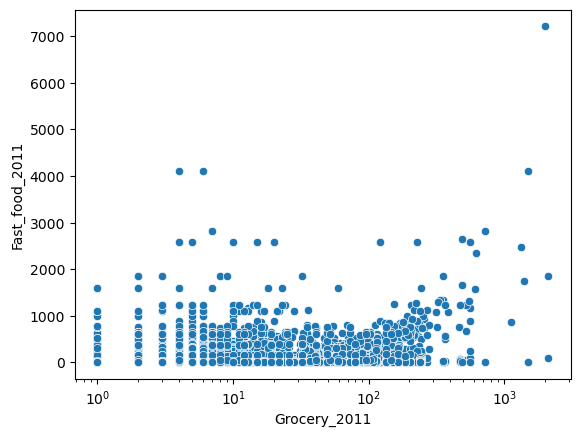

In [37]:
sns.scatterplot(data = grocery_to_fastfood, x = 'Grocery_2011', y= 'Fast_food_2011')
plt.xscale('log')
plt.show()

In [38]:
grocery_to_fast = duckdb.sql('SELECT grocery_to_fastfood.State, grocery_to_fastfood.County, grocery_to_fastfood.Grocery_2011,\
grocery_to_fastfood.Fast_food_2011, demographics.Percent_White_2010, demographics.Percent_Black_2010, \
demographics.Percent_Asian_2010, demographics.Percent_Hispanic_2010, demographics.Percent_Native_American_2010, \
demographics.Percent_Hawaiian_2010 FROM grocery_to_fastfood INNER JOIN demographics ON \
grocery_to_fastfood.County=demographics.County').df()

In [39]:
grocery_to_fast.head()

,State,County,Grocery_2011,Fast_food_2011,Percent_White_2010,Percent_Black_2010,Percent_Asian_2010,Percent_Hispanic_2010,Percent_Native_American_2010,Percent_Hawaiian_2010
0,AL,Autauga,5,34,77.246156,17.582599,0.855766,2.400542,0.397647,0.040314
1,AL,Baldwin,27,28,54.033246,41.264217,1.268591,2.010061,0.185914,0.039370
2,AL,Barbour,6,7,96.479595,0.723371,0.204955,0.578697,0.548556,0.018084
3,AL,Bibb,6,182,42.105602,51.909712,1.602088,2.821655,0.184510,0.047574
4,AL,Blount,7,63,92.057556,2.694090,0.701569,2.797334,0.296724,0.020324


In [40]:
majority_white = grocery_to_fast[grocery_to_fast['Percent_White_2010'] >= 50.0 ]
majority_black = grocery_to_fast[grocery_to_fast['Percent_Black_2010'] >= 50.0 ]
majority_hispanic = grocery_to_fast[grocery_to_fast['Percent_Hispanic_2010'] >= 50.0 ]
majority_NA = grocery_to_fast[grocery_to_fast['Percent_Native_American_2010'] >= 50.0 ]


majorities = [majority_white, majority_black, majority_hispanic, majority_NA]
# there are some ethnicities that don't have majority in any US county, so for data
# simplification purposes we have excluded those groups: Asian-Americans, Native Hawaiians
count = [x.shape[0] for x in majorities]
mean_groc = [x['Grocery_2011'].mean() for x in majorities]
mean_ff = [x['Fast_food_2011'].mean() for x in majorities]

data = {'Majority' : ['White', 'Black', 'Hispanic', 'Native_American'], 'Number_of_counties' : \
       count, 'Average_grocery_stores_2011' : mean_groc, 'Average_fast_food_2011': mean_ff}
majority_df = pd.DataFrame(data)
majority_df.head()

,Majority,Number_of_counties,Average_grocery_stores_2011,Average_fast_food_2011
0,White,182293,14.861569,56.836944
1,Black,8349,16.613726,66.867888
2,Hispanic,1019,21.789990,65.233562
3,Native_American,644,10.487578,43.468944


In [41]:
nys_df = duckdb.sql("SELECT * FROM stores AS stores \
INNER JOIN restaurants AS restaurants ON stores.County = restaurants.County\
                        INNER JOIN demographics AS dem ON stores.County = dem.County\
                        WHERE stores.State = 'NY' ORDER BY stores.County ASC").df()
nys_df = nys_df.drop_duplicates(subset = ['County'], keep='first')
print(nys_df.shape)
nys_df.keys()

(62, 42)


Index(['State', 'County', 'Grocery_2011', 'Grocery_2016',
       'Grocery_per_1000_2011', 'Grocery_per_1000_2016', 'Supercenter_2011',
       'Supercenter_2016', 'Supercenter_per_1000_2011',
       'Supercenter_per_1000_2016', 'Convenience_2011', 'Convenience_2016',
       'Convenience_per_1000_2011', 'Convenience_per_1000_2016',
       'Specialized_2011', 'Specialized_2016', 'Specialized_per_1000_2011',
       'Specialized_per_1000_2016', 'State_2', 'County_2', 'Fast_food_2011',
       'Fast_food_2016', 'Fast_food_per_1000_2011', 'Fast_food_per_1000_2016',
       'Full_service_2011', 'Full_service_2016', 'Full_service_per_1000_2011',
       'Full_service_per_1000_2016', 'Fast_food_expenditures_per_capita_2012',
       'Full_service_expenditures_per_capita_2012', 'State_3', 'County_3',
       'Percent_White_2010', 'Percent_Black_2010', 'Percent_Hispanic_2010',
       'Percent_Asian_2010', 'Percent_Native_American_2010',
       'Percent_Hawaiian_2010', 'Median_household_income_2015',
  

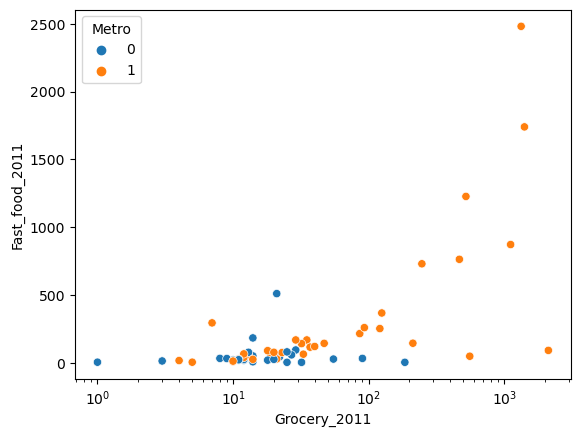

In [42]:
sns.scatterplot(data = nys_df, x = 'Grocery_2011', y= 'Fast_food_2011', hue='Metro')
plt.xscale('log')
# plt.yscale('log')
plt.show()

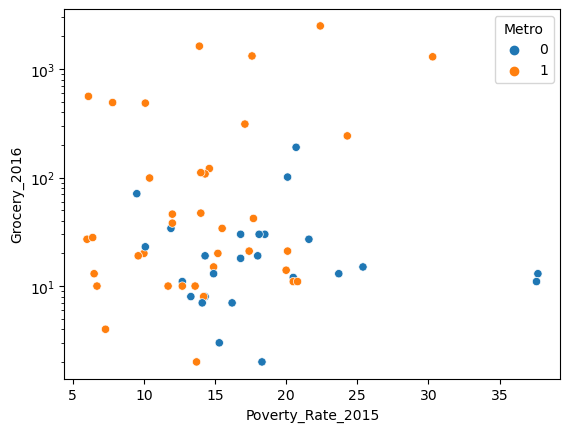

In [43]:
sns.scatterplot(data = nys_df, x='Poverty_Rate_2015', y = 'Grocery_2016', hue='Metro')
plt.yscale('log')
plt.show()

We next have to remove outliars from each column using IQR Calculations so we will iterate the formula for each column to receive our data set that has no outliars

In [44]:
nys_no_outliers = duckdb.sql('SELECT * FROM nys_df ORDER BY County ASC').df()
print(nys_no_outliers.shape)
nys_no_outliers.head()

(62, 42)


,State,County,Grocery_2011,Grocery_2016,Grocery_per_1000_2011,Grocery_per_1000_2016,Supercenter_2011,Supercenter_2016,Supercenter_per_1000_2011,Supercenter_per_1000_2016,...,Percent_White_2010,Percent_Black_2010,Percent_Hispanic_2010,Percent_Asian_2010,Percent_Native_American_2010,Percent_Hawaiian_2010,Median_household_income_2015,Poverty_Rate_2015,Child_poverty_rate_2015,Metro
0,NY,Albany,90,101,0.295241,0.326776,3,5,0.009841,0.016177,...,84.839803,1.074410,8.821180,2.768671,0.545470,0.046833,44455.0,20.1,15.9,0
1,NY,Allegany,12,14,0.245887,0.297177,0,0,0.000000,0.000000,...,88.157737,7.936127,1.444990,0.753792,0.119861,0.034626,39859.0,20.0,27.1,1
2,NY,Bronx,1115,1296,0.795917,0.882247,1,3,0.000714,0.002042,...,10.916766,30.083936,53.527451,3.417423,0.249800,0.028734,35102.0,30.3,42.6,1
3,NY,Broome,35,42,0.175483,0.215573,3,3,0.015041,0.015398,...,86.278166,4.411765,3.378863,3.499003,0.163509,0.029910,46067.0,17.7,23.2,1
4,NY,Cattaraugus,22,19,0.275589,0.244338,1,2,0.012527,0.025720,...,91.946910,1.202734,1.674614,0.652415,2.939602,0.017431,40933.0,18.0,26.1,0


In [45]:
# nys_no_outliers = duckdb.sql('SELECT Grocery_2011, Fast_food_2011,Grocery_2016, Fast_food_2016, Poverty_Rate_2015,\
# County, Metro, \
# Fast_food_per_1000_2016, Grocery_per_1000_2016, Percent_Black_2010, Percent_White_2010, Percent_Asian_2010,\
# Percent_Hispanic_2010,Percent_Native_American_2010, Percent_Hawaiian_2010 FROM nys_df ORDER BY County ASC').df()


In [46]:
columns = ['Grocery_2011','Grocery_2016','Fast_food_2011', 'Fast_food_2016']

for column in columns:
    data = nys_no_outliers[column].values.astype('float')
#     print(abs((data - data.mean())/data.std()))
    bool_test = abs((data - data.mean())/data.std()) > 3.0
    nys_no_outliers = nys_no_outliers[~bool_test]
    
nys_no_outliers.shape


(55, 42)

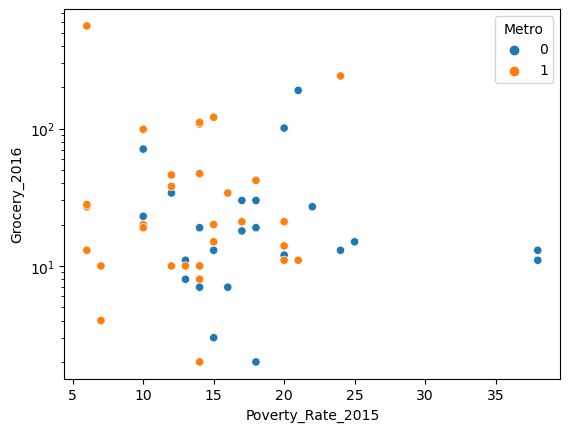

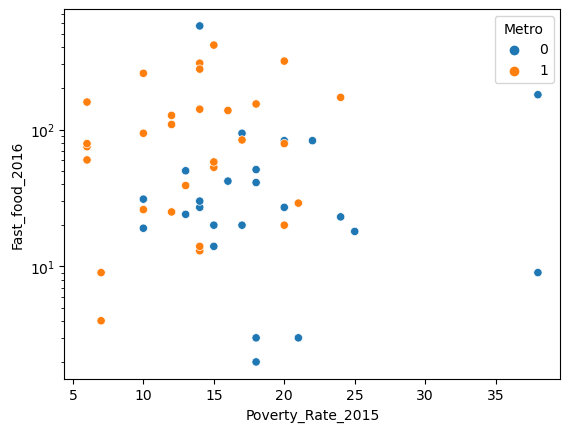

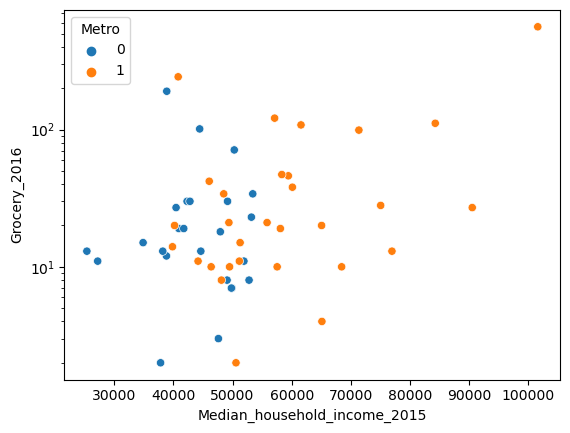

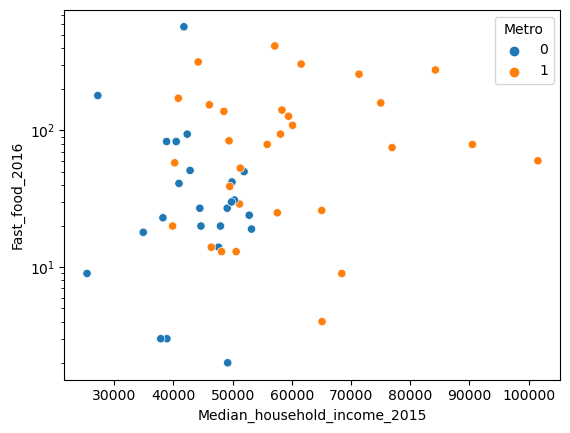

,State,County,Grocery_2011,Grocery_2016,Grocery_per_1000_2011,Grocery_per_1000_2016,Supercenter_2011,Supercenter_2016,Supercenter_per_1000_2011,Supercenter_per_1000_2016,...,Percent_White_2010,Percent_Black_2010,Percent_Hispanic_2010,Percent_Asian_2010,Percent_Native_American_2010,Percent_Hawaiian_2010,Median_household_income_2015,Poverty_Rate_2015,Child_poverty_rate_2015,Metro
0,NY,Albany,90,101,0.30,0.33,3,5,0.01,0.02,...,84.84,1.07,8.82,2.77,0.55,0.05,44455.0,20.0,15.9,0
1,NY,Allegany,12,14,0.25,0.30,0,0,0.00,0.00,...,88.16,7.94,1.44,0.75,0.12,0.03,39859.0,20.0,27.1,1
3,NY,Broome,35,42,0.18,0.22,3,3,0.02,0.02,...,86.28,4.41,3.38,3.50,0.16,0.03,46067.0,18.0,23.2,1
4,NY,Cattaraugus,22,19,0.28,0.24,1,2,0.01,0.03,...,91.95,1.20,1.67,0.65,2.94,0.02,40933.0,18.0,26.1,0
5,NY,Cayuga,14,11,0.18,0.14,2,2,0.03,0.03,...,91.34,3.76,2.37,0.48,0.31,0.03,51925.0,13.0,20.3,0


In [47]:
nys_no_outliers['Poverty_Rate_2015'] = nys_no_outliers['Poverty_Rate_2015'].round(0)
nys_no_outliers = nys_no_outliers.round(2)
sns.scatterplot(data = nys_no_outliers, x='Poverty_Rate_2015', y = 'Grocery_2016', hue= 'Metro')
plt.yscale('log')
plt.show()
sns.scatterplot(data = nys_no_outliers, x='Poverty_Rate_2015', y = 'Fast_food_2016', hue= 'Metro')
plt.yscale('log')
plt.show()
sns.scatterplot(data = nys_no_outliers, x='Median_household_income_2015', y = 'Grocery_2016', hue= 'Metro')
plt.yscale('log')
plt.show()
sns.scatterplot(data = nys_no_outliers, x='Median_household_income_2015', y = 'Fast_food_2016', hue= 'Metro')
plt.yscale('log')
plt.show()
nys_no_outliers.head()

Below are the scatterplot graphs from the no outliar data set comparing county ethnic makeups for each present ethnic group('Hawaiians' did not makeup larger than 1% in all counties within New York so we excluded that group as we deemed it not significant to the impact of grocery stores and fast food venues). We additionally compared the median house_hold income of each county to the new york house hold median, as we feel additional information can be learned from this.

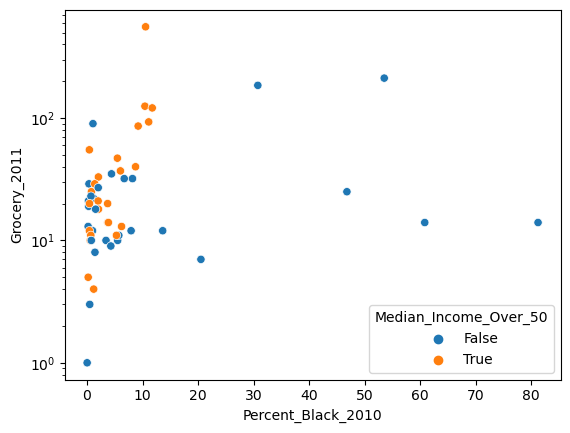

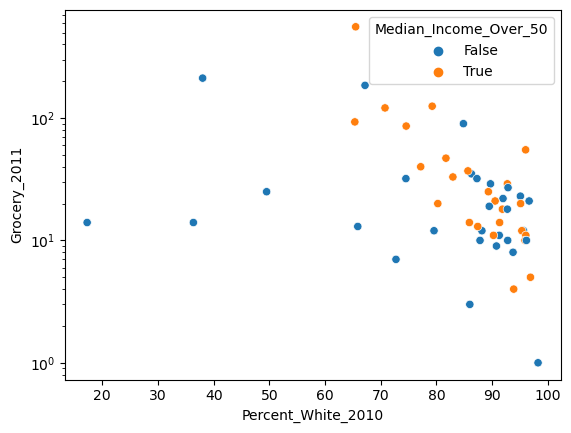

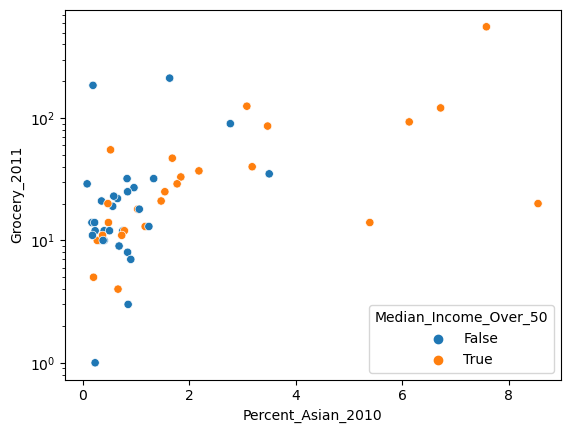

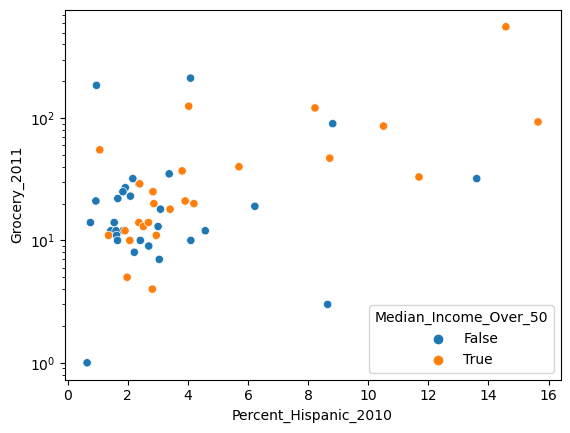

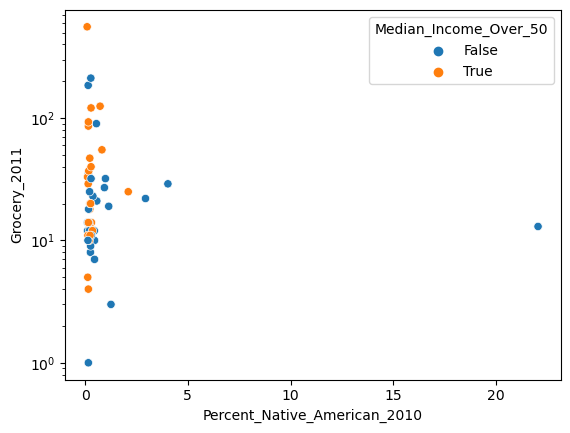

In [48]:
nys_no_outliers['Median_Income_Over_50'] = nys_no_outliers['Median_household_income_2015'] > 50000
sns.scatterplot(data = nys_no_outliers, x='Percent_Black_2010', y = 'Grocery_2011', hue='Median_Income_Over_50')
plt.yscale('log')
plt.show()
sns.scatterplot(data = nys_no_outliers, x='Percent_White_2010', y = 'Grocery_2011', hue='Median_Income_Over_50')
plt.yscale('log')
plt.show()
sns.scatterplot(data = nys_no_outliers, x='Percent_Asian_2010', y = 'Grocery_2011', hue='Median_Income_Over_50')
plt.yscale('log')
plt.show()
sns.scatterplot(data = nys_no_outliers, x='Percent_Hispanic_2010', y = 'Grocery_2011', hue='Median_Income_Over_50')
plt.yscale('log')
plt.show()
sns.scatterplot(data = nys_no_outliers, x='Percent_Native_American_2010', y = 'Grocery_2011', hue='Median_Income_Over_50')
plt.yscale('log')
plt.show()

Similar to the above mapping grocery stores to the ethnic composition of counties in New York, we repeated this but graphed ethnic percentages of each major ethnic group in the county to the number of fast food venues in that county. Again, Hawaiians' did not makeup larger than 1% in all counties within New York so we excluded that group as we deemed it not significant to the impact of grocery stores and fast food venues. 

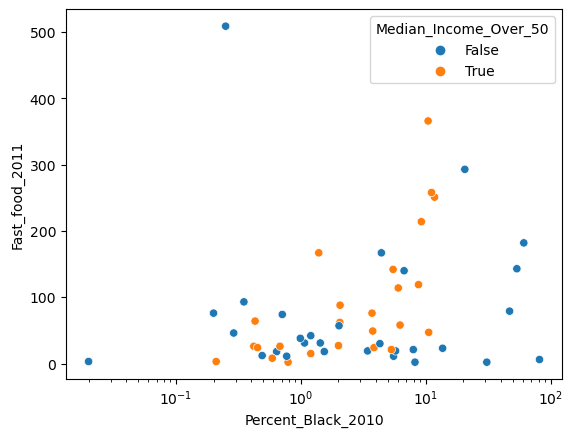

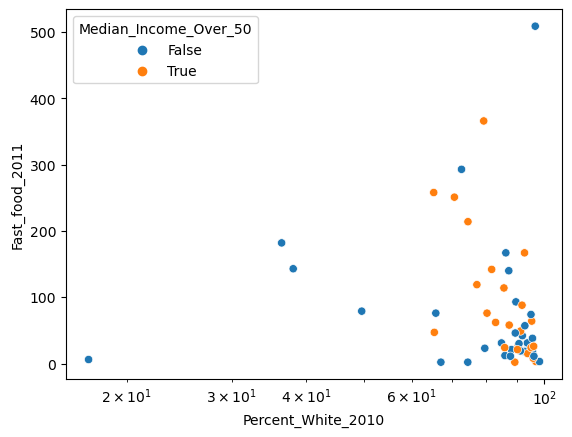

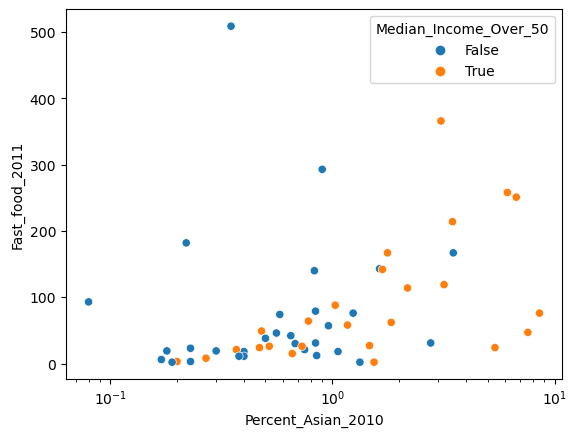

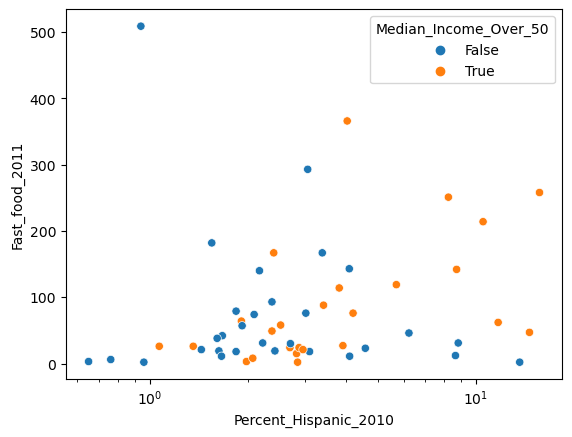

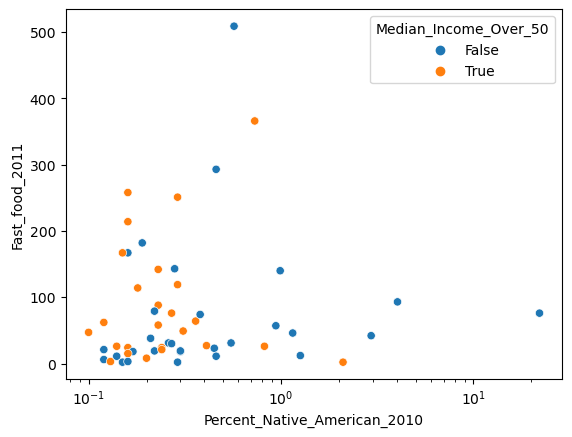

In [49]:
nys_no_outliers['Median_Income_Over_50'] = nys_no_outliers['Median_household_income_2015'] > 50000
sns.scatterplot(data = nys_no_outliers, x='Percent_Black_2010', y = 'Fast_food_2011', hue='Median_Income_Over_50')
plt.xscale('log')
plt.show()
sns.scatterplot(data = nys_no_outliers, x='Percent_White_2010', y = 'Fast_food_2011', hue='Median_Income_Over_50')
plt.xscale('log')
plt.show()
sns.scatterplot(data = nys_no_outliers, x='Percent_Asian_2010', y = 'Fast_food_2011', hue='Median_Income_Over_50')
plt.xscale('log')
plt.show()
sns.scatterplot(data = nys_no_outliers, x='Percent_Hispanic_2010', y = 'Fast_food_2011', hue='Median_Income_Over_50')
plt.xscale('log')
plt.show()
sns.scatterplot(data = nys_no_outliers, x='Percent_Native_American_2010', y = 'Fast_food_2011', hue='Median_Income_Over_50')
plt.xscale('log')
plt.show()

